In [13]:
import sys
print(sys.executable)

# this prevents the need to restart the kernel every time a local module is changed
%load_ext autoreload
%autoreload 2

/grad/sguotong/.conda/envs/.cavGZ_venv/bin/python


In [14]:
from include.bessel import initialize_bessel_table, BesselJZeros, BesselJpZeros
initialize_bessel_table(10, 10)

# print out a table of BesselJZeros
print("BesselJZeros (m,n): \n")
print("k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |\n")
for n in range(1, 6):
    str_out = f"{n} |"
    for m in range(0, 6):
        str_out += f" {BesselJZeros(m, n):.5f} |"

    print(str_out)

print("\n https://mathworld.wolfram.com/BesselFunctionZeros.html")

BesselJZeros (m,n): 

k |  J_0(x) |  J_1(x) |  J_2(x) |  J_3(x) |  J_4(x) |  J_5(x) |

1 | 2.40483 | 3.83171 | 5.13562 | 6.38016 | 7.58834 | 8.77148 |
2 | 5.52008 | 7.01559 | 8.41724 | 9.76102 | 11.06471 | 12.33860 |
3 | 8.65373 | 10.17347 | 11.61984 | 13.01520 | 14.37254 | 15.70017 |
4 | 11.79153 | 13.32369 | 14.79595 | 16.22347 | 17.61597 | 18.98013 |
5 | 14.93092 | 16.47063 | 17.95982 | 19.40942 | 20.82693 | 22.21780 |

 https://mathworld.wolfram.com/BesselFunctionZeros.html


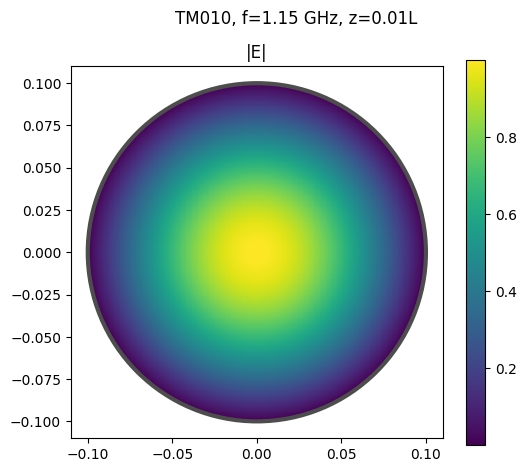

In [15]:
from include.cavity_modes import CavityModeHelper
import numpy as np
import matplotlib.pyplot as plt

a = 0.1  # radius in meters
L = 0.5  # length in meters
family = "TE"
m, n, p = 2, 1, 2
sign = "-"
cavHelper = CavityModeHelper(a, L)
w_TE212 = cavHelper.omega_mnp(family, m, n, p)
f_TE212 = w_TE212/(2*np.pi)*0.3  # in GHz
Er, Ephi, Ez = cavHelper.mode_fn_callables(family, m, n, p, sign)

# plot a slice near z=0
# THIS SHOULD BE MOVED TO A HELPER FILE IN THE FUTURE
def plot_disk_slice(Fr, Fphi, Fz, a, z0, *, r_pts=200, ph_pts=200, title="", func_name="", show_components=False):
    x = np.linspace(-a, a, 2*r_pts)
    y = np.linspace(-a, a, 2*r_pts)
    X, Y = np.meshgrid(x, y, indexing="xy")
    R = np.hypot(X, Y)
    Phi = np.arctan2(Y, X)
    Z = np.full_like(R, z0)
    disk = R <= a
    eps = 1e-6

    Frv = Fr(R, Phi, Z)
    Fphiv = Fphi(R, Phi, Z)
    Fzv = Fz(R, Phi, Z)

    Fr_real, Fr_imag, Fr_mag = np.real(Frv), np.imag(Frv), np.abs(Frv)
    Fphi_real, Fphi_imag, Fphi_mag = np.real(Fphiv), np.imag(Fphiv), np.abs(Fphiv)
    Fz_real, Fz_imag, Fz_mag = np.real(Fzv), np.imag(Fzv), np.abs(Fzv)
    norm = np.sqrt(Fr_mag**2 + Fphi_mag**2 + Fz_mag**2)

    # one plot of the norm
    fig2, ax2 = plt.subplots(figsize=(6, 5))
    norm = np.where(disk, norm, np.nan)
    plt_norm = ax2.pcolormesh(X, Y, norm, shading="auto", cmap="viridis", zorder=1)
        # vector plot on top of norm plot
    Fx = Fr_imag * np.cos(Phi) - Fphi_imag * np.sin(Phi)
    Fy = Fr_imag * np.sin(Phi) + Fphi_imag * np.cos(Phi)
    Fxy_mag = np.sqrt(Fx**2 + Fy**2) + eps
    Fx /= Fxy_mag
    Fy /= Fxy_mag
            # mask outside the disk and avoid singular arrows near |F|≈0

    U = np.where(disk, Fx, np.nan)
    V = np.where(disk, Fy, np.nan)
    M = np.where(disk, Fxy_mag, np.nan)
            # normalize stream directions
    L = np.sqrt(U**2 + V**2)
    U = U / (L + eps)
    V = V / (L + eps)
    U[L < eps] = np.nan; V[L < eps] = np.nan
    sp = ax2.streamplot(
        X, Y, U, V,
        density=1.2,
        color="k",
        linewidth=0.5,
        arrowsize=0.7,
        minlength=0.05, maxlength=0.1,
        integration_direction="both",
        broken_streamlines=False,
        zorder=2,
    )

    ax2.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
    ax2.set_aspect("equal", "box")
    ax2.set_xlim(-1.1*a, 1.1*a); ax2.set_ylim(-1.1*a, 1.1*a)
    ax2.set_title(f"|{func_name}|")
    fig2.colorbar(plt_norm, ax=ax2)
    plt.suptitle(title or f"Disk slice at z={z0:.3g}")
    plt.show()

    if not show_components: return
    
    # plot 3*3 subplots of magnitude
    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    comp_dict = {
        "r": (Fr_real, Fr_imag, Fr_mag),
        "phi": (Fphi_real, Fphi_imag, Fphi_mag),
        "z": (Fz_real, Fz_imag, Fz_mag)
    }
    for i, key in enumerate(["r", "phi", "z"]):
        real, imag, mag = comp_dict[key]
        real = np.where(disk, real, np.nan)
        imag = np.where(disk, imag, np.nan)
        mag = np.where(disk, mag, np.nan)

        ax_real, ax_imag, ax_mag = axs[i, 0], axs[i, 1], axs[i, 2]
        plt_real = ax_real.pcolormesh(X, Y, real, shading="auto", cmap="viridis")
        ax_real.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_real.set_aspect("equal", "box")
        ax_real.set_xlim(-1.1*a, 1.1*a); ax_real.set_ylim(-1.1*a, 1.1*a)
        ax_real.set_title(f"Re({func_name}_{key})")

        plt_imag = ax_imag.pcolormesh(X, Y, imag, shading="auto", cmap="viridis")
        ax_imag.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_imag.set_aspect("equal", "box")
        ax_imag.set_xlim(-1.1*a, 1.1*a); ax_imag.set_ylim(-1.1*a, 1.1*a)
        ax_imag.set_title(f"Im({func_name}_{key})")

        plt_mag = ax_mag.pcolormesh(X, Y, mag, shading="auto", cmap="viridis")
        ax_mag.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))
        ax_mag.set_aspect("equal", "box")
        ax_mag.set_xlim(-1.1*a, 1.1*a); ax_mag.set_ylim(-1.1*a, 1.1*a)
        ax_mag.set_title(f"|{func_name}_{key}|")

    fig.colorbar(plt_mag, ax=axs.ravel().tolist())
    plt.suptitle(title or f"Disk slice at z={z0:.3g}")
    plt.show()

z0_over_L = 0.01
z0 = z0_over_L * L
title = f"{family}{m}{n}{p}, f={f_TE212:.3g} GHz, z={z0_over_L:.3g}L"
plot_disk_slice(Er, Ephi, Ez, a, z0, title=title, func_name="E")

family = "TM"
m, n, p = 0, 1, 0
sign = "-"
w_TM010 = cavHelper.omega_mnp(family, m, n, p)
f_TM010 = w_TM010/(2*np.pi)*0.3  # in GHz
Er, Ephi, Ez = cavHelper.mode_fn_callables(family, m, n, p, sign)
title = f"{family}{m}{n}{p}, f={f_TM010:.3g} GHz, z={z0_over_L:.3g}L"
plot_disk_slice(Er, Ephi, Ez, a, z0, title=title, func_name="E")


In [17]:
from include.j_eff import j_eff_callables
pol = "+"
Jr, Jphi, Jz = j_eff_callables(pol, w_TM010, 0, 0, 0)
plot_disk_slice(Jr, Jphi, Jz, a, z0, title=f"TE212, f={f_TE212:.3g} GHz, z={z0_over_L:.3g}L", func_name="j_eff")

In [4]:
from include.cavity_modes import CavityModeHelper
import numpy as np

a, L = 0.1, 0.5
Nr, Nphi, Nz = 200, 256, 96
r = np.linspace(0.0, a, Nr, endpoint=True)
phi = np.linspace(0.0, 2*np.pi, Nphi, endpoint=False)
z = np.linspace(-L/2, +L/2, Nz, endpoint=True)

R3, PHI3, Z3 = np.meshgrid(r, phi, z, indexing="ij")   # shape: [Nr, Nphi, Nz]

family = "TE"
m, n, p = 2, 1, 2

cavHelper = CavityModeHelper(a, L)
Er, Ephi, Ez = cavHelper.mode_fn_vectorized(R3, PHI3, Z3, family, m, n, p)
w_mnp = cavHelper.omega_mnp(family, m, n, p)
f_mnp = w_mnp/(2*np.pi)*0.3  # in GHz
print(f"{family}{m}{n}{p}, f={f_mnp:.3g} GHz")

TE212, f=1.58 GHz


Function to plot vectorized mode functions:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_mode_disk_slice(
    cav,
    family: str, m: int, n: int, p: int, sign: str = "+",
    r: np.ndarray = None,
    phi: np.ndarray = None,
    z0: float = 0.0,
    cart_N: int = 300,
    stream_density: float = 1.2,
    stream_lw: float = 0.8,
    clim: tuple | None = None,
    title: str | None = None,
):
    """
    Visualize a cylindrical cavity mode on a disk slice z = z0.

    - Color: amplitude |E| (phasor magnitude) on the slice
    - Streamlines: normalized in-plane direction (Re[Ex], Re[Ey]) at t=0

    Parameters
    ----------
    cav : CavityModeHelper
        The helper instance that provides mode_fn_vectorized and geometry.
    family, m, n, p, sign : see your API
    r, phi : 1D arrays
        Radial and azimuthal coordinates used to build the polar grid.
        If omitted, reasonable defaults are chosen from cav.a.
    z0 : float
        Slice height (meters).
    cart_N : int
        Resolution of the internal Cartesian interpolation grid (cart_N x cart_N).
    stream_density : float
        Matplotlib streamplot density parameter.
    stream_lw : float
        Linewidth for streamlines.
    clim : (vmin, vmax) or None
        Fix the color scale for amplitude if desired.
    title : str or None
        Custom title.

    Notes
    -----
    - Uses the **phasor magnitude** for color: sqrt(|Ex|^2 + |Ey|^2 + |Ez|^2).
    - Uses the **real part** of (Ex, Ey) for direction at phase t=0.
    - Converts (Er, Ephi, Ez) to (Ex, Ey, Ez) via the usual cylindrical basis.
    - Interpolates to a regular (x,y) grid for streamplot; pcolormesh uses the original polar mesh.
    """
    # Defaults for polar grid if not provided
    a = cav.a
    if r is None:
        r = np.linspace(0.0, a, 256, endpoint=True)
    if phi is None:
        phi = np.linspace(0.0, 2*np.pi, 384, endpoint=False)

    # Build polar mesh at the requested z
    R, PHI = np.meshgrid(r, phi, indexing="ij")
    Z = np.full_like(R, z0, dtype=float)

    # Get cylindrical field components (complex phasors)
    Er, Ephi, Ez = cav.mode_fn_vectorized(R, PHI, Z, family, m, n, p)

    # Convert to Cartesian components on the slice
    cph, sph = np.cos(PHI), np.sin(PHI)
    Ex = Er * cph - Ephi * sph
    Ey = Er * sph + Ephi * cph

    # Amplitude for color (phasor magnitude)
    Amp = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

    # For direction: take real part at t = 0
    U = np.real(Ex)
    V = np.real(Ey)

    # Coordinates in the plane
    X = R * cph
    Y = R * sph

    # -------- Figure and background amplitude (pcolormesh on polar grid) --------
    fig, ax = plt.subplots(figsize=(6.5, 6))
    # pcolormesh supports non-rectangular grids via X, Y arrays of same shape
    # Use shading="auto" to avoid warnings with nonuniform quad shape
    pcm = ax.pcolormesh(X, Y, Amp, shading="auto")
    if clim is not None:
        pcm.set_clim(*clim)
    cbar = fig.colorbar(pcm, ax=ax, pad=0.02)
    cbar.set_label(r"$|E|\;(\mathrm{arb.})$")

    # -------- Interpolate to a regular Cartesian grid for streamplot --------
    # Regular square covering the disk
    x_lin = np.linspace(-a, a, cart_N)
    y_lin = np.linspace(-a, a, cart_N)
    XX, YY = np.meshgrid(x_lin, y_lin, indexing="xy")
    RR = np.sqrt(XX**2 + YY**2)
    disk_mask = RR <= a

    # Prepare scattered data: (X, Y) -> values
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Interpolate U, V and normalize
    Uc = griddata(points, U.ravel(), (XX, YY), method="cubic", fill_value=0.0)
    Vc = griddata(points, V.ravel(), (XX, YY), method="cubic", fill_value=0.0)

    # Mask outside disk
    Uc[~disk_mask] = 0.0
    Vc[~disk_mask] = 0.0

    # Normalize to unit vectors for streamplot direction only
    speed = np.hypot(Uc, Vc)
    with np.errstate(invalid="ignore", divide="ignore"):
        Uhat = np.where(speed > 0, Uc / speed, 0.0)
        Vhat = np.where(speed > 0, Vc / speed, 0.0)

    # Streamplot overlaid
    ax.streamplot(
        x_lin, y_lin, Uhat, Vhat,
        density=stream_density,
        linewidth=stream_lw,
        arrowsize=1.0,
        maxlength=2.0,
        minlength=0.05,
    )

    ax.add_patch(plt.Circle((0, 0), a, edgecolor="0.3", facecolor="none", linewidth=3, zorder=3))

    # Formatting
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-1.1*a, 1.1*a)
    ax.set_ylim(-1.1*a, 1.1*a)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    if title is None:
        title = f"{family}{m}{n}{p}{sign} @ z={z0:g} m"
    ax.set_title(title)
    ax.grid(False)
    plt.tight_layout()
    return fig, ax


In [11]:
fig, ax = plot_mode_disk_slice(cavHelper, family, m, n, p, r=r, phi=phi, z0=0.01*L)
plt.show()

/tmp/ipykernel_413734/1732510318.py:85: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(X, Y, Amp, shading="auto")


In [8]:
from include.antenna_pattern import antenna_pattern

pol = "x"
beta = np.linspace(0, np.pi, 180, endpoint=True)
eta_TE212_x = antenna_pattern(r, phi, z, Er, Ephi, Ez, pol=pol, wg=w_mnp, a=a, L=L, beta=beta, alpha=0.0, psi=0.0,savefile='eta_TE212_x.npy')

Norm is 0.003119800375793583
E shape after broadcasting: (200, 256, 96, 1)
Calculating j_eff...


KeyboardInterrupt: 

Plot antenna pattern:

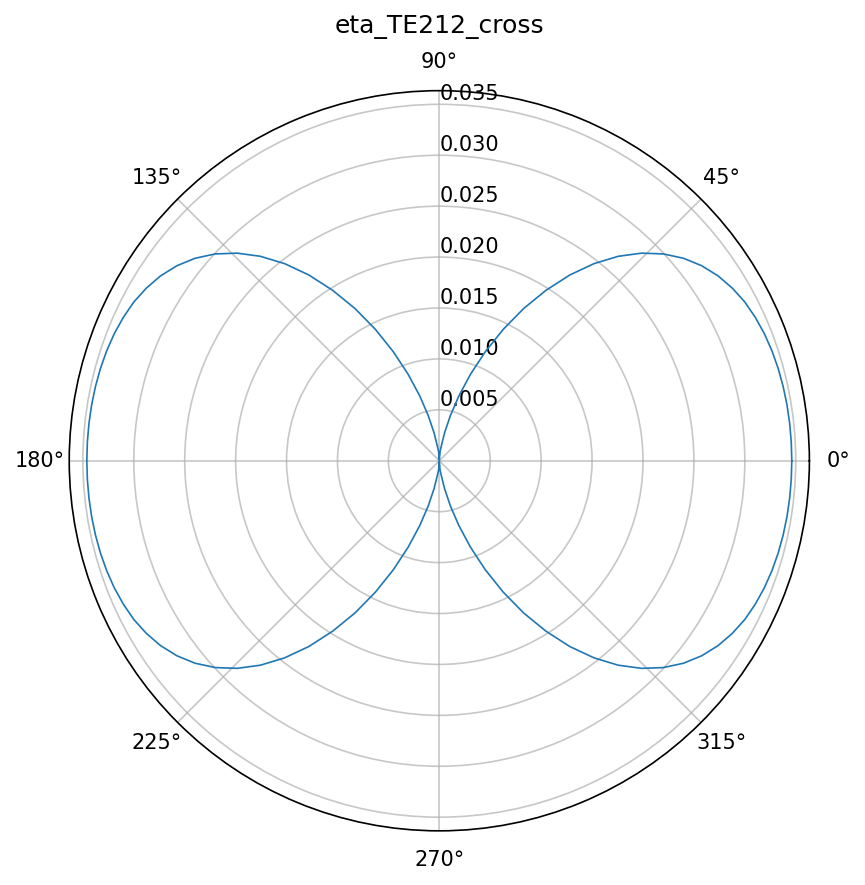

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

PATH = "eta_TE212_x.npy"

eta = np.load(PATH)                        # shape (Nb, Na, Npsi)
curve = eta[:, 0, 0].astype(float)         # take α=0, ψ=0 slice
Nb = curve.size
beta = np.linspace(0.0, np.pi, Nb, endpoint=True)

# Mirror to cover 0..2π without duplicating endpoints
theta_full = np.r_[beta, beta + np.pi]
r_full     = np.r_[curve, curve]

fig = plt.figure(figsize=(6,6), dpi=150)
ax = plt.subplot(111, projection="polar")
ax.plot(theta_full, r_full, linewidth=0.8)
ax.set_theta_zero_location("E")  #type:ignore            # 0° at the right
ax.set_theta_direction(1)        #type:ignore            # ccw
ax.set_rlabel_position(90)       #type:ignore            # radial labels at 90°
ax.grid(True, linewidth=0.8, alpha=0.7)
ax.set_title(PATH.replace(".npy",""), va="bottom")
plt.tight_layout()
plt.show()
